In [79]:
%load_ext rpy2.ipython
%R library(dplyr);library(magrittr);library(ggplot2); library(parody); library(reshape);library(gridExtra)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Loading required package: grid


In [2]:
%%R
p<-read.csv("./data/phage.genome.info.txt", header=TRUE, sep="\t")
t<-read.csv("./data/bulk_phage_trna_summary.txt",header=TRUE, sep="\t")

p$ncbi_acc<-gsub(" ","",p$ncbi_acc)
t$phage_full<-gsub(" ","", t$phage_full)


#delete rows that are from partial genomes or genes:
p<-p[!grepl("' 'gene|partial|protein",p$name),]
t<-t[!grepl("' 'gene|partial|protein",t$phage_short),]

t$phage_short%>%unique%>%length%>%print
p$ncbi_acc%>%unique%>%length%>%print

t%>%group_by(phage_full)%>%summarise(trna_count=n())->txp_sum
p$trna_count<-txp_sum$trna_count[match(p$ncbi_acc, txp_sum$phage_full)]
p[is.na(p)]<-0


[1] 985
[1] 3079


In [3]:
%%R
head(p)

trna_binary=vector()
trna_bin=vector()

for (i in p$trna_count){
    if (i>0){
        trna_binary<-c(trna_binary, 1)
    } else {trna_binary<-c(trna_binary, 0)}}
for (i in p$trna_count){
    if (i>=20){
        trna_bin<-c(trna_bin, "high")
    } else if (5<i & i<20) {
        trna_bin<-c(trna_bin, "med")
    } else if (i<=5 & i>1) {
        trna_bin<-c(trna_bin, "low")
    } else if (i==1){
        trna_bin<-c(trna_bin, "one")
    }
    else {
        trna_bin<-c(trna_bin, "none")
    }}

p<-cbind.data.frame(p, trna_binary, trna_bin)    
head(p)

     ncbi_acc                               name        tax   size       gc
1  KF582788.2     Escherichia phage vB_EcoM_JS09 Myoviridae 169148 37.64928
2  HQ630627.1           Pseudomonas phage PhiPA3 Myoviridae 309208 47.72548
3 NC_024794.1  Escherichia phage vB_EcoM_PhAPEC2 Myoviridae 167318 37.72517
4  JX080304.2          Staphylococcus phage MSA6 Myoviridae 148243 30.24291
5  JX080305.2           Staphylococcus phage P4W Myoviridae 147590 30.39163
6  JX080303.2        Staphylococcus phage Fi200W Myoviridae 148481 30.39311
  trna_count trna_binary trna_bin
1          2           1      low
2          4           1      low
3          3           1      low
4          4           1      low
5          4           1      low
6          4           1      low


In [4]:
%%R
caudos<-p[grepl("Myoviridae|Podoviridae|Siphoviridae",p$tax),]

host<-vector()

for (i in caudos$name){
    m<-strsplit(i, " ")
    host<-c(host, (unlist(m)[2]))
    }
host<-gsub("Mycobacteriophage","Mycobacterium", host)
host<-gsub("Cyanophage","Synechococcus", host)
host<-gsub("Vibriophage","Vibrio", host)
host<-gsub("Lactoccoccus","Lactococcus",host)
#host<-gsub("Bacteriophage","Escherechia", host)
host<-gsub("Enterobacterial|Enterobacteriophage|Enterobacteriaphage","Enterobacteria", host)
host<-gsub("Iodobacteriophage","Iodobacter", host)
caudos<-cbind.data.frame(caudos, host)
caudos%>%group_by(host)%>%summarise(phage_count=n())%>%.[order(-.$phage_count),]->hp_count
#print(hp_count$host[order(hp_count$host)])
print(hp_count)

Source: local data frame [136 x 2]

                host phage_count
1      Mycobacterium         499
2      Synechococcus         183
3     Enterobacteria         156
4        Pseudomonas         154
5     Staphylococcus         141
6      Bacteriophage         122
7           Bacillus          94
8             Vibrio          79
9         Salmonella          78
10 Propionibacterium          77
..               ...         ...


In [5]:
%%R
caudos$ncbi_acc%>%unique%>%length%>%print
caudos[!caudos$trna_count==0,]%>%nrow%>%print

[1] 2518
[1] 949


In [30]:
%%R
inquiry<-"Pelagibacter"
number<-"NC_02048"
print(caudos[caudos$host==inquiry,])
#caudos[grepl(number, caudos$ncbi_acc),]



        ncbi_acc                         name         tax   size       gc
899  NC_020484.1  Pelagibacter phage HTVC008M  Myoviridae 147284 33.44830
1503 NC_020483.1  Pelagibacter phage HTVC019P Podoviridae  42084 34.04619
1585 NC_020482.1  Pelagibacter phage HTVC011P Podoviridae  39921 31.95812
1997 NC_020481.1  Pelagibacter phage HTVC010P Podoviridae  34892 31.96721
     trna_count trna_binary trna_bin         host
899           1           1      one Pelagibacter
1503          1           1      one Pelagibacter
1585          1           1      one Pelagibacter
1997          0           0     none Pelagibacter


In [36]:
%%R

pp<-caudos[caudos$host==inquiry,]%>%.$ncbi_acc
host<-caudos[caudos$host==inquiry,]%>%.$host%>%unique
pp<-c(pp,host)

[1] Pelagibacter
136 Levels: Achromobacter Acidithiobacillus Acinetobacter ... Yersinia


In [38]:
%Rpull pp
import subprocess
import os
#os.mkdir("sar11")

for p in pp[0:4]:
    subprocess.call(["scp", "jbrown@eofe4.mit.edu:/nobackup1/jbrown/tRNA/pgenomes/"+p+".gbk", "./sar11/"])

In [41]:
pp[4]="Pelagibacter"

In [44]:
from tRNA_functions import *

for p in pp:
    name=p
    a="./sar11/"+p+".gbk"
    gbk_to_fasta(gbk=a, output="./sar11/"+name+".fasta")
    gbk_to_cds_fasta(gbk=a, output="./sar11/"+name+".cds.fasta")
    run_trna_scan(input_file="./sar11/"+name+".fasta", output="./sar11/"+name+".trna")
    run_codonM(fasta="./sar11/"+name+".cds.fasta", output="./sar11/"+name+".m")
    run_codonW(fasta="./sar11/"+name+".cds.fasta", outfile="./sar11/"+name+".w")
    extract_cds_annotations(gbfile=a, outputfile="./sar11/"+name+".cds.annotations.txt")

198 CDS sequences extracted from ./sar11/NC_020484.1.gbk
tRNA scan of ./sar11/NC_020484.1.fasta is done!
198 annotated features in ./sar11/NC_020484.1.gbk
59 CDS sequences extracted from ./sar11/NC_020483.1.gbk
tRNA scan of ./sar11/NC_020483.1.fasta is done!
59 annotated features in ./sar11/NC_020483.1.gbk
45 CDS sequences extracted from ./sar11/NC_020482.1.gbk
tRNA scan of ./sar11/NC_020482.1.fasta is done!
45 annotated features in ./sar11/NC_020482.1.gbk
64 CDS sequences extracted from ./sar11/NC_020481.1.gbk
tRNA scan of ./sar11/NC_020481.1.fasta is done!
64 annotated features in ./sar11/NC_020481.1.gbk
1334 CDS sequences extracted from ./sar11/Pelagibacter.gbk
tRNA scan of ./sar11/Pelagibacter.fasta is done!
1334 annotated features in ./sar11/Pelagibacter.gbk


In [47]:
%%R -i pp
source("./scripts/ptcs_code.R")

pp[1:4]
pp[5]

[1] "Pelagibacter"


In [52]:
%%R -i pp

combo<-data.frame(gene_order=integer(),title=character(),Nc=integer(),GC3s=integer(),GC=integer(),L_aa=integer(),gene_ptcs=integer(),product=character(),host=factor(), phage=factor())

paccs<-pp[1:3]  #fourth phage does not have tRNAs
h<-pp[5]

for (n in seq(1,length(paccs))){
p=paccs[n]

codonlist<-read.table(paste("./sar11/",p,".trna",sep=""), skip=3, header=FALSE,sep="\t")
codonlist$V6%>%unique->codonlist

for (j in c(p, h)){
    codonm<-format_codon_m(paste("./sar11/",j,".m", sep=""),paste("./sar11/",j,".w", sep=""))
    hcodonm<-format_codon_m(paste("./sar11/",h,".m", sep=""),paste("./sar11/",h,".w", sep=""))
    codonw<-read.table(paste("./sar11/",j,".w", sep=""))
    gene_ptcs<-calculate_genome_ptcs(codonm=codonm, hcodonm=hcodonm, codonw=codonw, codonlist=codonlist)
    
    host_w<-read.table(paste("./sar11/",j,".w", sep=""), header=TRUE, sep="\t", na.strings="*****")
    host_w$X<-NULL
    cbind.data.frame(host_w, gene_ptcs)->host_w
    gene_order<-seq(1:nrow(host_w))
    host_w<-cbind.data.frame(gene_order, host_w)
    annotations<-read.csv(paste("./sar11/",j,".cds.annotations.txt",sep=""), header=TRUE, sep="\t")
    host_w$title<-gsub(" ","",host_w$title)
    annotations$title<-gsub(" ","",annotations$title)
    host_w$product<-annotations$product[match(host_w$title, annotations$title)]
    host_w$host<-j
    host_w$phage<-p
    combo<-rbind(host_w, combo)
}}

Read 12078 items
Read 81374 items
Read 81374 items
Read 81374 items
Read 3599 items
Read 81374 items
Read 81374 items
Read 81374 items
Read 2745 items
Read 81374 items
Read 81374 items
Read 81374 items


[1] "NC_020482.1"
[1] "NC_020483.1"
[1] "NC_020484.1"


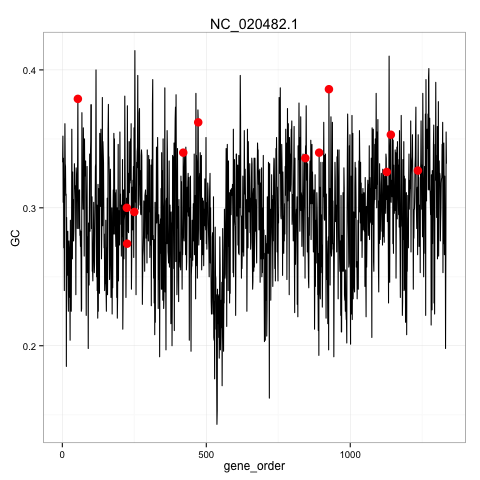

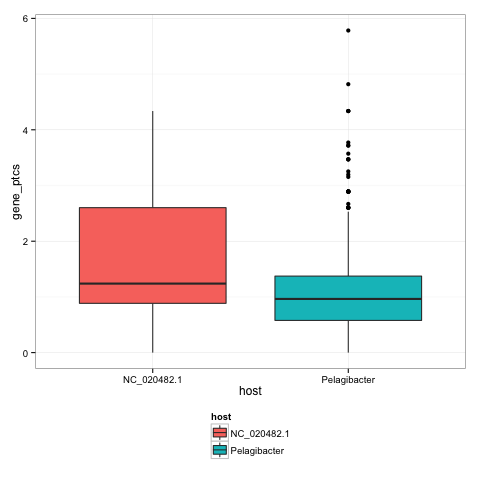

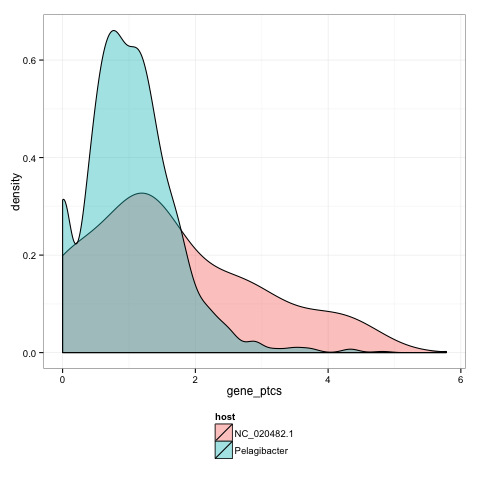

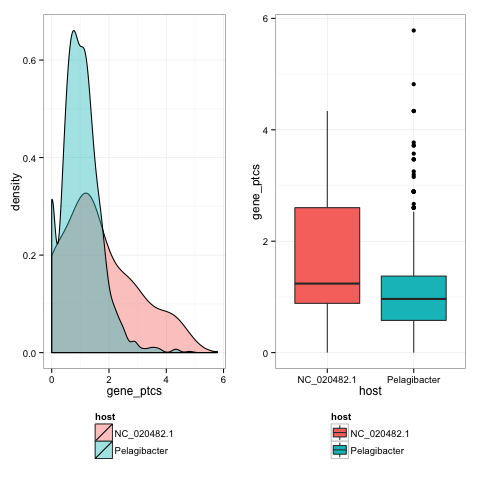

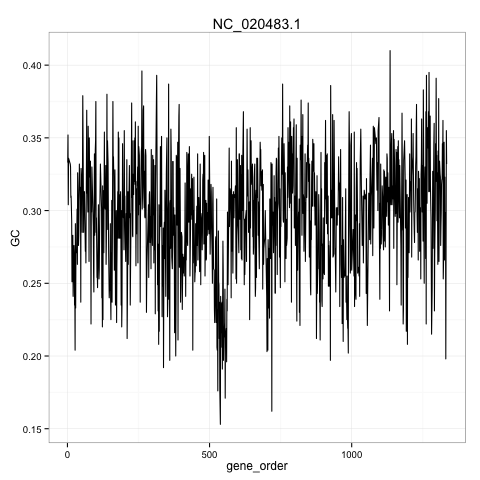

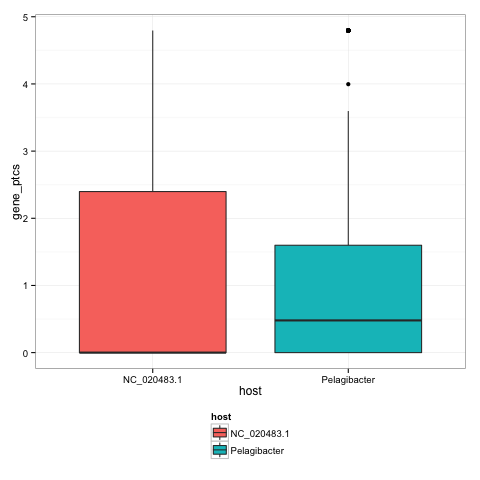

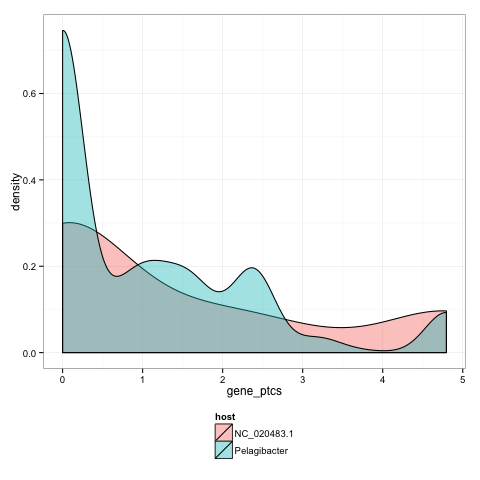

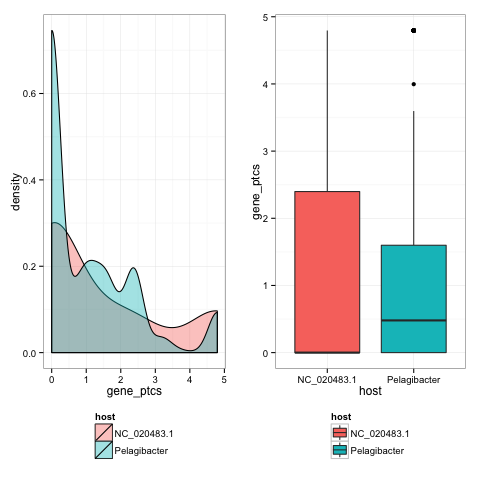

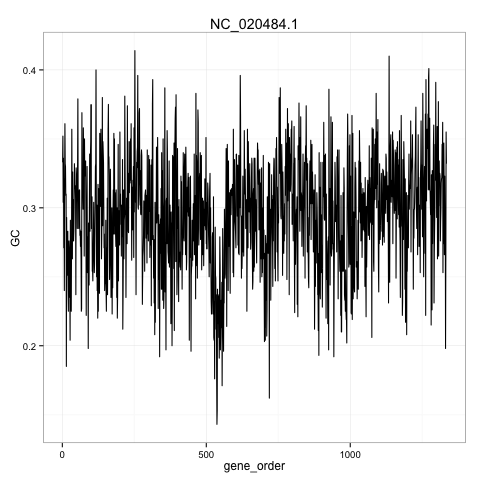

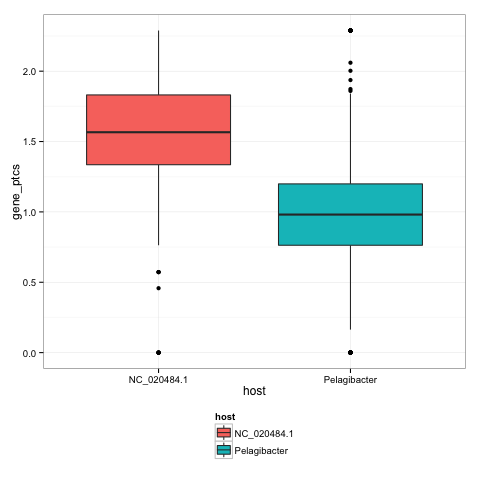

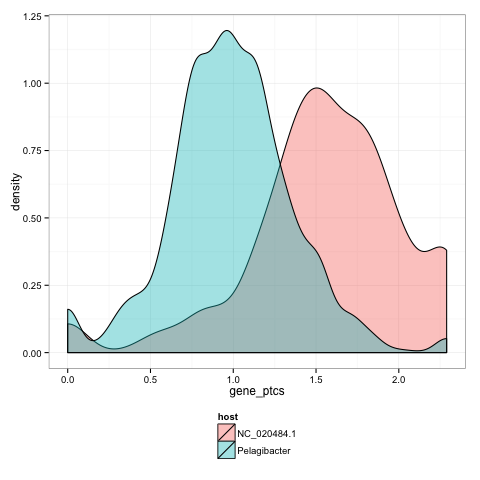

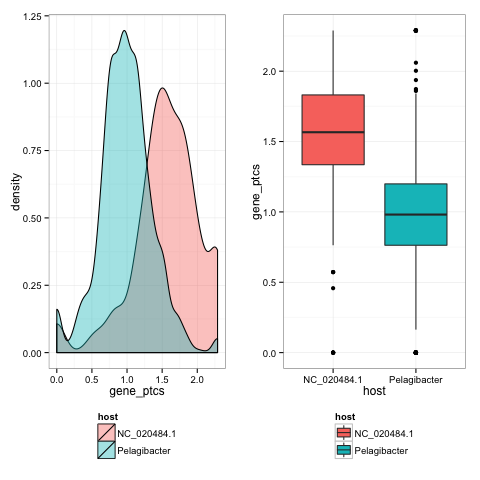

In [82]:
%%R 
for (h in unique(as.factor(combo$phage))){
    print(h)
    combo%>%filter(phage==h, host=="Pelagibacter")%>%na.omit->indiv
    outliers<-calout.detect(indiv$gene_ptcs, alpha=0.05, method="boxplot")
    #print(indiv[outliers$ind,8]%>%na.omit)
    
    #check host genes that have ptcs score above the lower limit of phage genome top quaritile
    #combo%>%filter(phage==h, host==h)%>%.$gene_ptcs%>%boxplot.stats(coef=1.5, do.conf=TRUE, do.out=TRUE)%>%.$stats%>%.[4]->thresh
    #indiv%>%filter(gene_ptcs>thresh)%>%.[,8]%>%print
    
    
    j<-ggplot(indiv, aes(gene_order, GC))+geom_line()+
        geom_point(data= indiv[outliers$ind,],color="red", cex=4, aes(x=gene_order, y=GC))+labs(title=h)
        #geom_point(data= filter(indiv, gene_ptcs>thresh),color="red", cex=4, aes(x=gene_order, y=GC))+labs(title=h)
    j<-j+theme_bw()
    plot(j)
    
    combo%>%filter(phage==h)->indiv1
    k<-ggplot(indiv1, aes(host, gene_ptcs, fill=host))+geom_boxplot()+theme_bw()#+geom_jitter()
    k<-k+theme(legend.position="bottom", legend.direction="vertical")
    plot(k)
    
    l<-ggplot(indiv1, aes(gene_ptcs, fill=host))+geom_density(alpha=0.4)+theme_bw()
    l<-l+theme(legend.position="bottom", legend.direction="vertical")
    plot(l)
    
    grid.arrange(l, k, ncol=2, nrow=1)
    }